# Skip warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')



# Libraries

In [2]:
!pip install category_encoders==2.6.2

In [1]:
!pip install torch torchvision

In [2]:
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [45 lines of output]
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
          self.avg_cltr_i = avg_cltr_i
          self.avg_cocltr = avg_cocltr
  
          return self
  
      def compute_averages(self, np.ndarray[np.int_t] cltr_u,
                                               ^
  ------------------------------------------------------------
  
  surprise\prediction_algorithms\co_clustering.pyx:157:45: Invalid type.
  Compiling surprise/similarities.pyx because it changed.
  Compiling surprise/prediction_algorithms/matrix_factorization.pyx because it changed.
  Compiling surprise/prediction_algorithms/optimize_baselines.pyx because it changed.
  Compiling surprise/prediction_algorithms/slope_one.pyx because it changed.
  Compiling surprise/prediction_algorithms/co_clustering.pyx because it changed.
  [1/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from surprise import Dataset, Reader, SVD
from surprise import accuracy
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mlflow
import mlflow.pytorch


ModuleNotFoundError: No module named 'tensorflow'

#Read Data

In [8]:
DF = pd.read_csv('Crop_recommendation.csv')

#EDA

In [9]:
DF.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [10]:
# Display rows with label 'orange'
orange_rows = DF[DF['label'] == 'orange']
print(orange_rows)

       N   P   K  temperature   humidity        ph    rainfall   label
1600  22  30  12    15.781442  92.510777  6.354007  119.035002  orange
1601  37   6  13    26.030973  91.508193  7.511755  101.284774  orange
1602  27  13   6    13.360506  91.356082  7.335158  111.226688  orange
1603   7  16   9    18.879577  92.043045  7.813917  114.665951  orange
1604  20   7   9    29.477417  91.578029  7.129137  111.172750  orange
...   ..  ..  ..          ...        ...       ...         ...     ...
1695  27  30   5    32.717485  90.546083  7.656978  113.328978  orange
1696  13   8  12    25.162966  92.547360  7.105905  114.311720  orange
1697   6   7   7    27.681673  94.473169  7.199106  113.999515  orange
1698  40  17  15    21.350934  90.949297  7.871063  107.086209  orange
1699  31  26   9    11.698946  93.256389  7.566166  103.200599  orange

[100 rows x 8 columns]


In [11]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [12]:
DF.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


##Number of crop categories

In [13]:
DF['label'].nunique()

22

###Class distribution and balance check

The dataset is perfectly balanced.
In this case, there is no need for over-sampling or under-sampling

In [14]:
DF['label'].value_counts()

,count
label,
rice,100
maize,100
jute,100
cotton,100
coconut,100
papaya,100
orange,100
apple,100
muskmelon,100


###Check missing values

No missing values in the dataset

In [15]:
DF.isnull().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


###Renaming the columns

In [16]:
DF.rename(columns={'label': 'crop'}, inplace=True)


In [17]:
DF.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'crop'], dtype='object')

###Feature Correlation Analysis

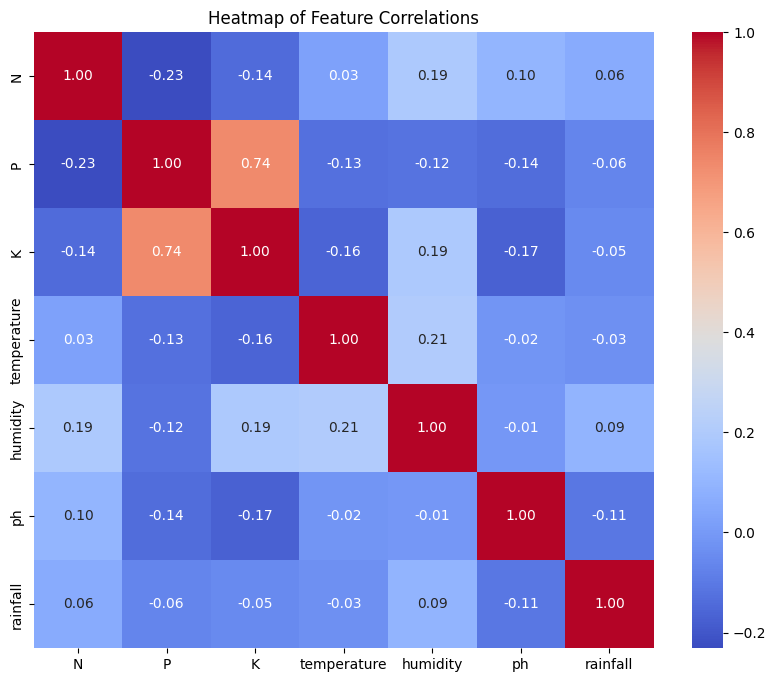

In [18]:
Corr_DF = DF.drop(columns=['crop'])
correlation_matrix = pd.DataFrame(Corr_DF).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Feature Correlations")
plt.show()

###Check and handling Outliers

We will not remove the outliers, because in our case, outliers are a natural part of the data distribution and removing them can significantly impact the model's ability to generalize.

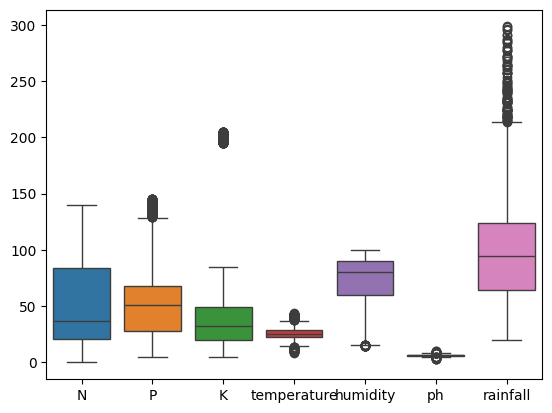

In [19]:
# excluding 'crop'
cols_to_plot = [col for col in DF.columns if col !='crop' ]

# Box plot
sns.boxplot(data=DF[cols_to_plot])
plt.show()

###Splitting Data

In [20]:
X = DF[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = DF[['crop']]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True,random_state=42, stratify=y)

In [22]:
X_temp = X_test
y_temp = y_test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True,random_state=42, stratify=y_temp)

###Binary Encoding


In [23]:
encoder = BinaryEncoder()
encoder.fit(y_train)
transformed_y_train = encoder.transform(y_train)
transformed_y_test = encoder.transform(y_test)
transformed_y_val = encoder.transform(y_val)

In [24]:
print(transformed_y_train.sum())

crop_0    560
crop_1    640
crop_2    880
crop_3    880
crop_4    880
dtype: int64


In [25]:
transformed_y_train.isnull().sum()

,0
crop_0,0
crop_1,0
crop_2,0
crop_3,0
crop_4,0


In [26]:
transformed_y_test.isnull().sum()

,0
crop_0,0
crop_1,0
crop_2,0
crop_3,0
crop_4,0


In [27]:
transformed_y_val.isnull().sum()

,0
crop_0,0
crop_1,0
crop_2,0
crop_3,0
crop_4,0


In [28]:
transformed_y_train

,crop_0,crop_1,crop_2,crop_3,crop_4
1607,0,0,0,0,1
1212,0,0,0,1,0
362,0,0,0,1,1
566,0,0,1,0,0
1671,0,0,0,0,1
...,...,...,...,...,...
808,0,0,1,1,1
422,0,1,1,0,1
2052,1,0,0,0,1
2083,1,0,0,0,1


In [29]:
encoded_df = pd.concat([transformed_y_train, y_train], axis=1)
encoded_df.drop_duplicates()

,crop_0,crop_1,crop_2,crop_3,crop_4,crop
1607,0,0,0,0,1,orange
1212,0,0,0,1,0,grapes
362,0,0,0,1,1,kidneybeans
566,0,0,1,0,0,mothbeans
1917,0,0,1,0,1,cotton
1015,0,0,1,1,0,banana
846,0,0,1,1,1,lentil
691,0,1,0,0,0,mungbean
2198,0,1,0,0,1,coffee
1420,0,1,0,1,0,muskmelon


###Scaling

Since we have outliers, we will need to use the robust scaler.

In [30]:
scaler = RobustScaler()
scaler.fit(X_train)
transformed_x_train = scaler.transform(X_train)
transformed_x_test = scaler.transform(X_test)
transformed_x_val = scaler.transform(X_val)

Before scaling

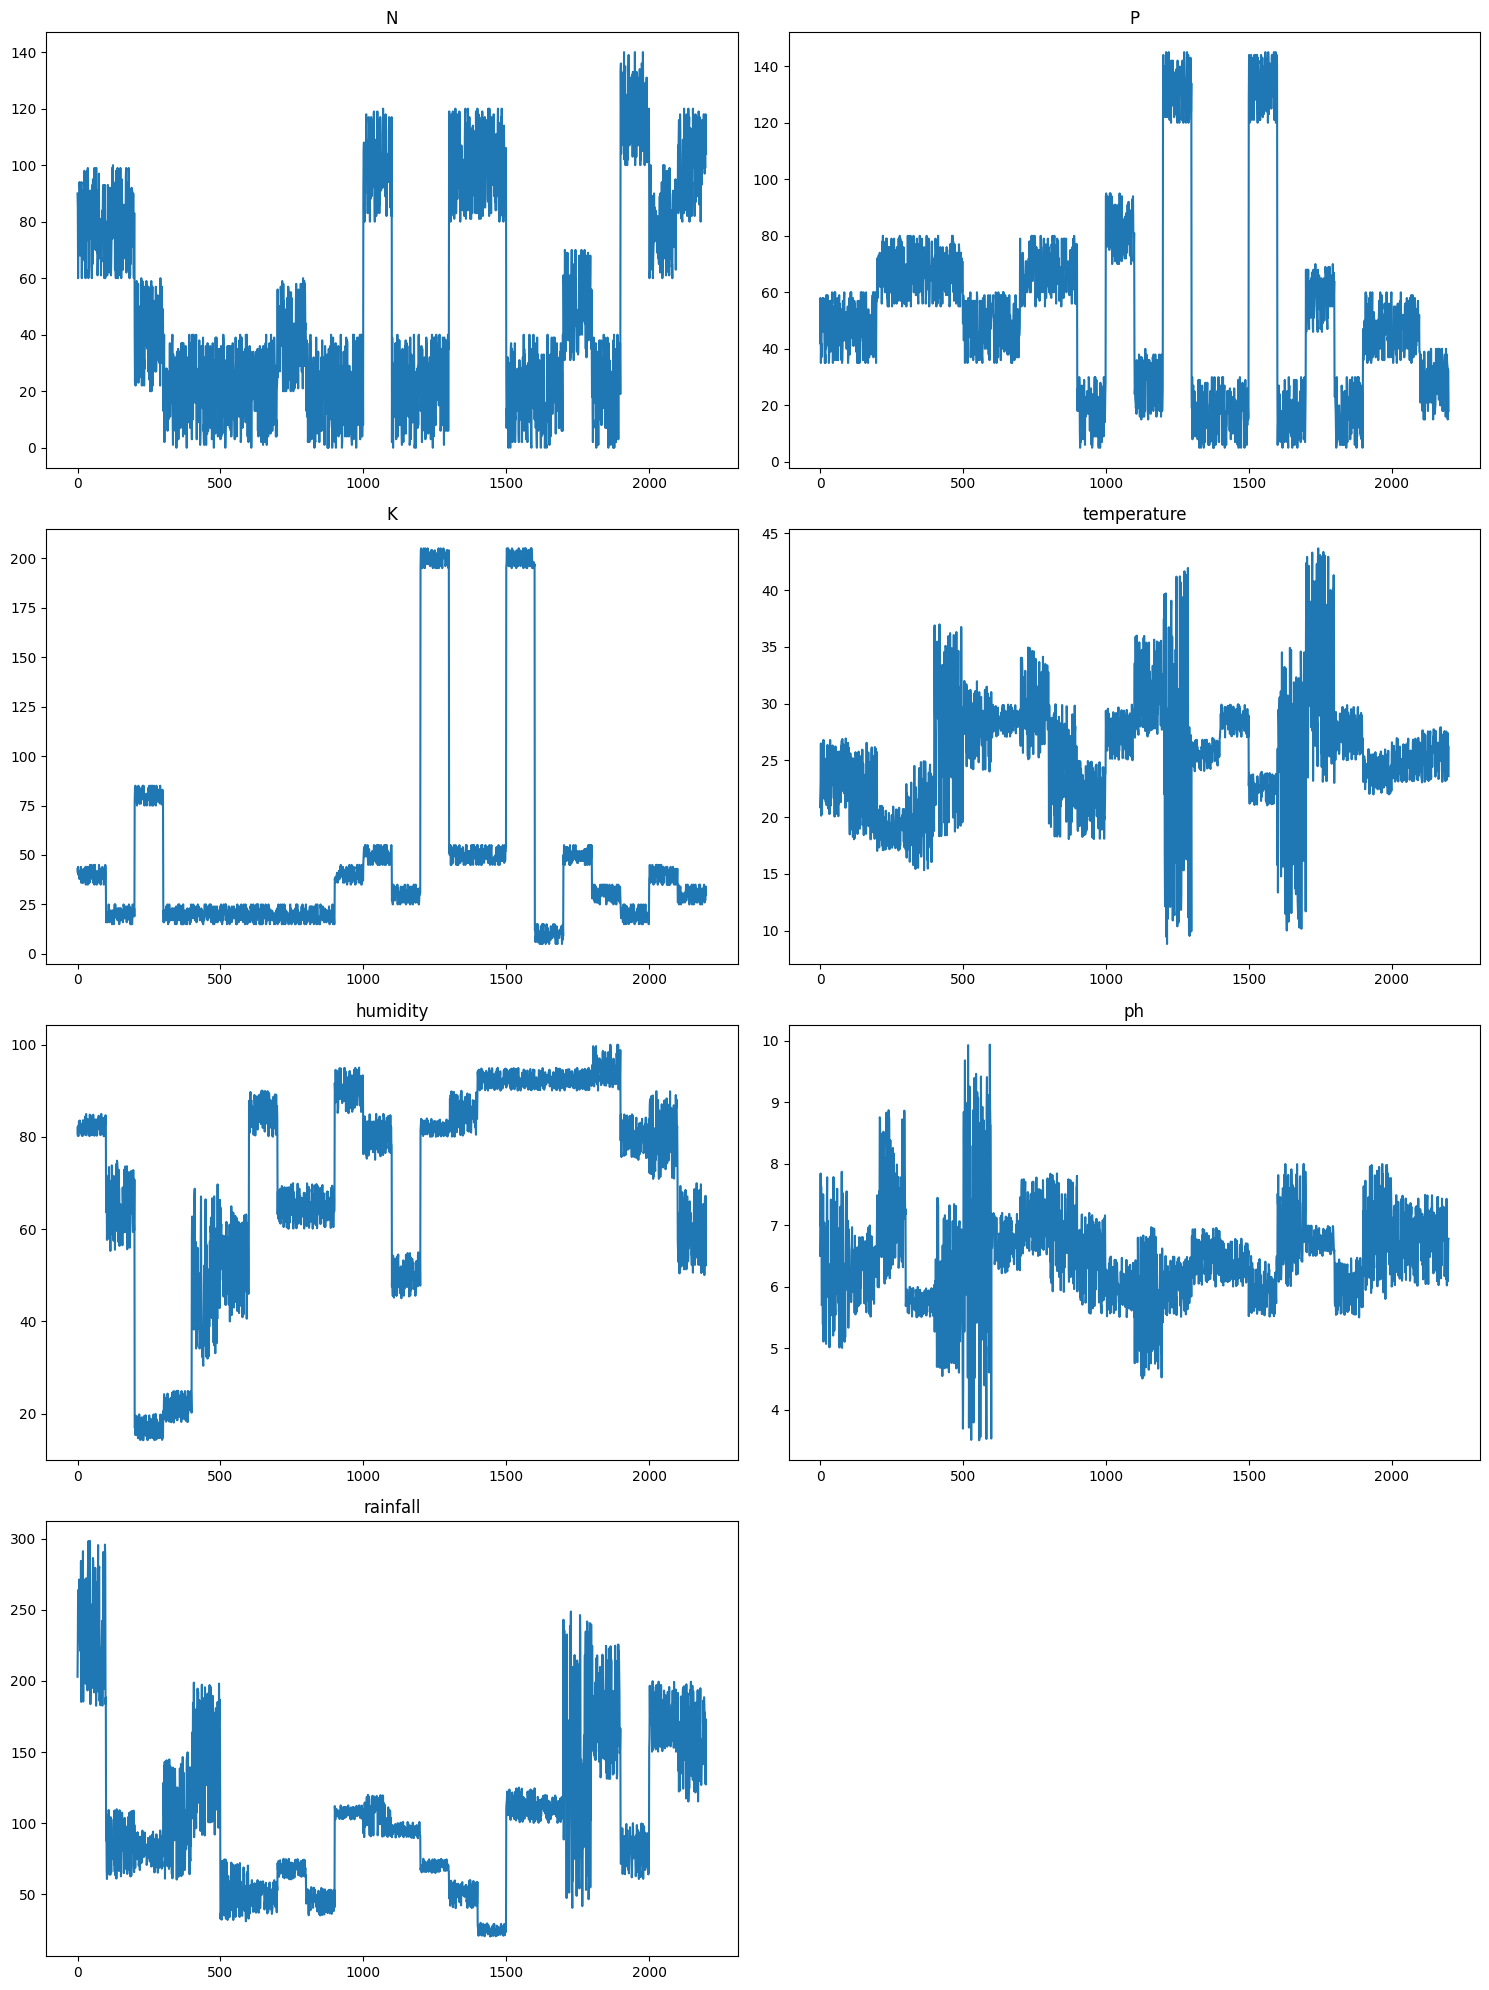

In [31]:
# Define columns
columns_to_plot = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Calculate the number of rows and columns for subplots
num_cols = 2  # Number of columns per row
num_rows = int(np.ceil(len(columns_to_plot) / num_cols))  # Calculate rows needed

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate through columns and plot
for i, column in enumerate(columns_to_plot):
    row = i // num_cols  # Calculate row index
    col = i % num_cols  # Calculate column index

    # Check if axes is a 1D array (single row)
    if num_rows == 1:
        ax = axes[col]  # Access subplot directly
    else:
        ax = axes[row, col]  # Access subplot using row and column index

    ax.plot(DF[column])
    ax.set_title(column)

# Hide any empty subplots (if total plots are not a multiple of 2)
for i in range(len(columns_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')  # Hide empty subplot

plt.tight_layout()
plt.show()

After scaling

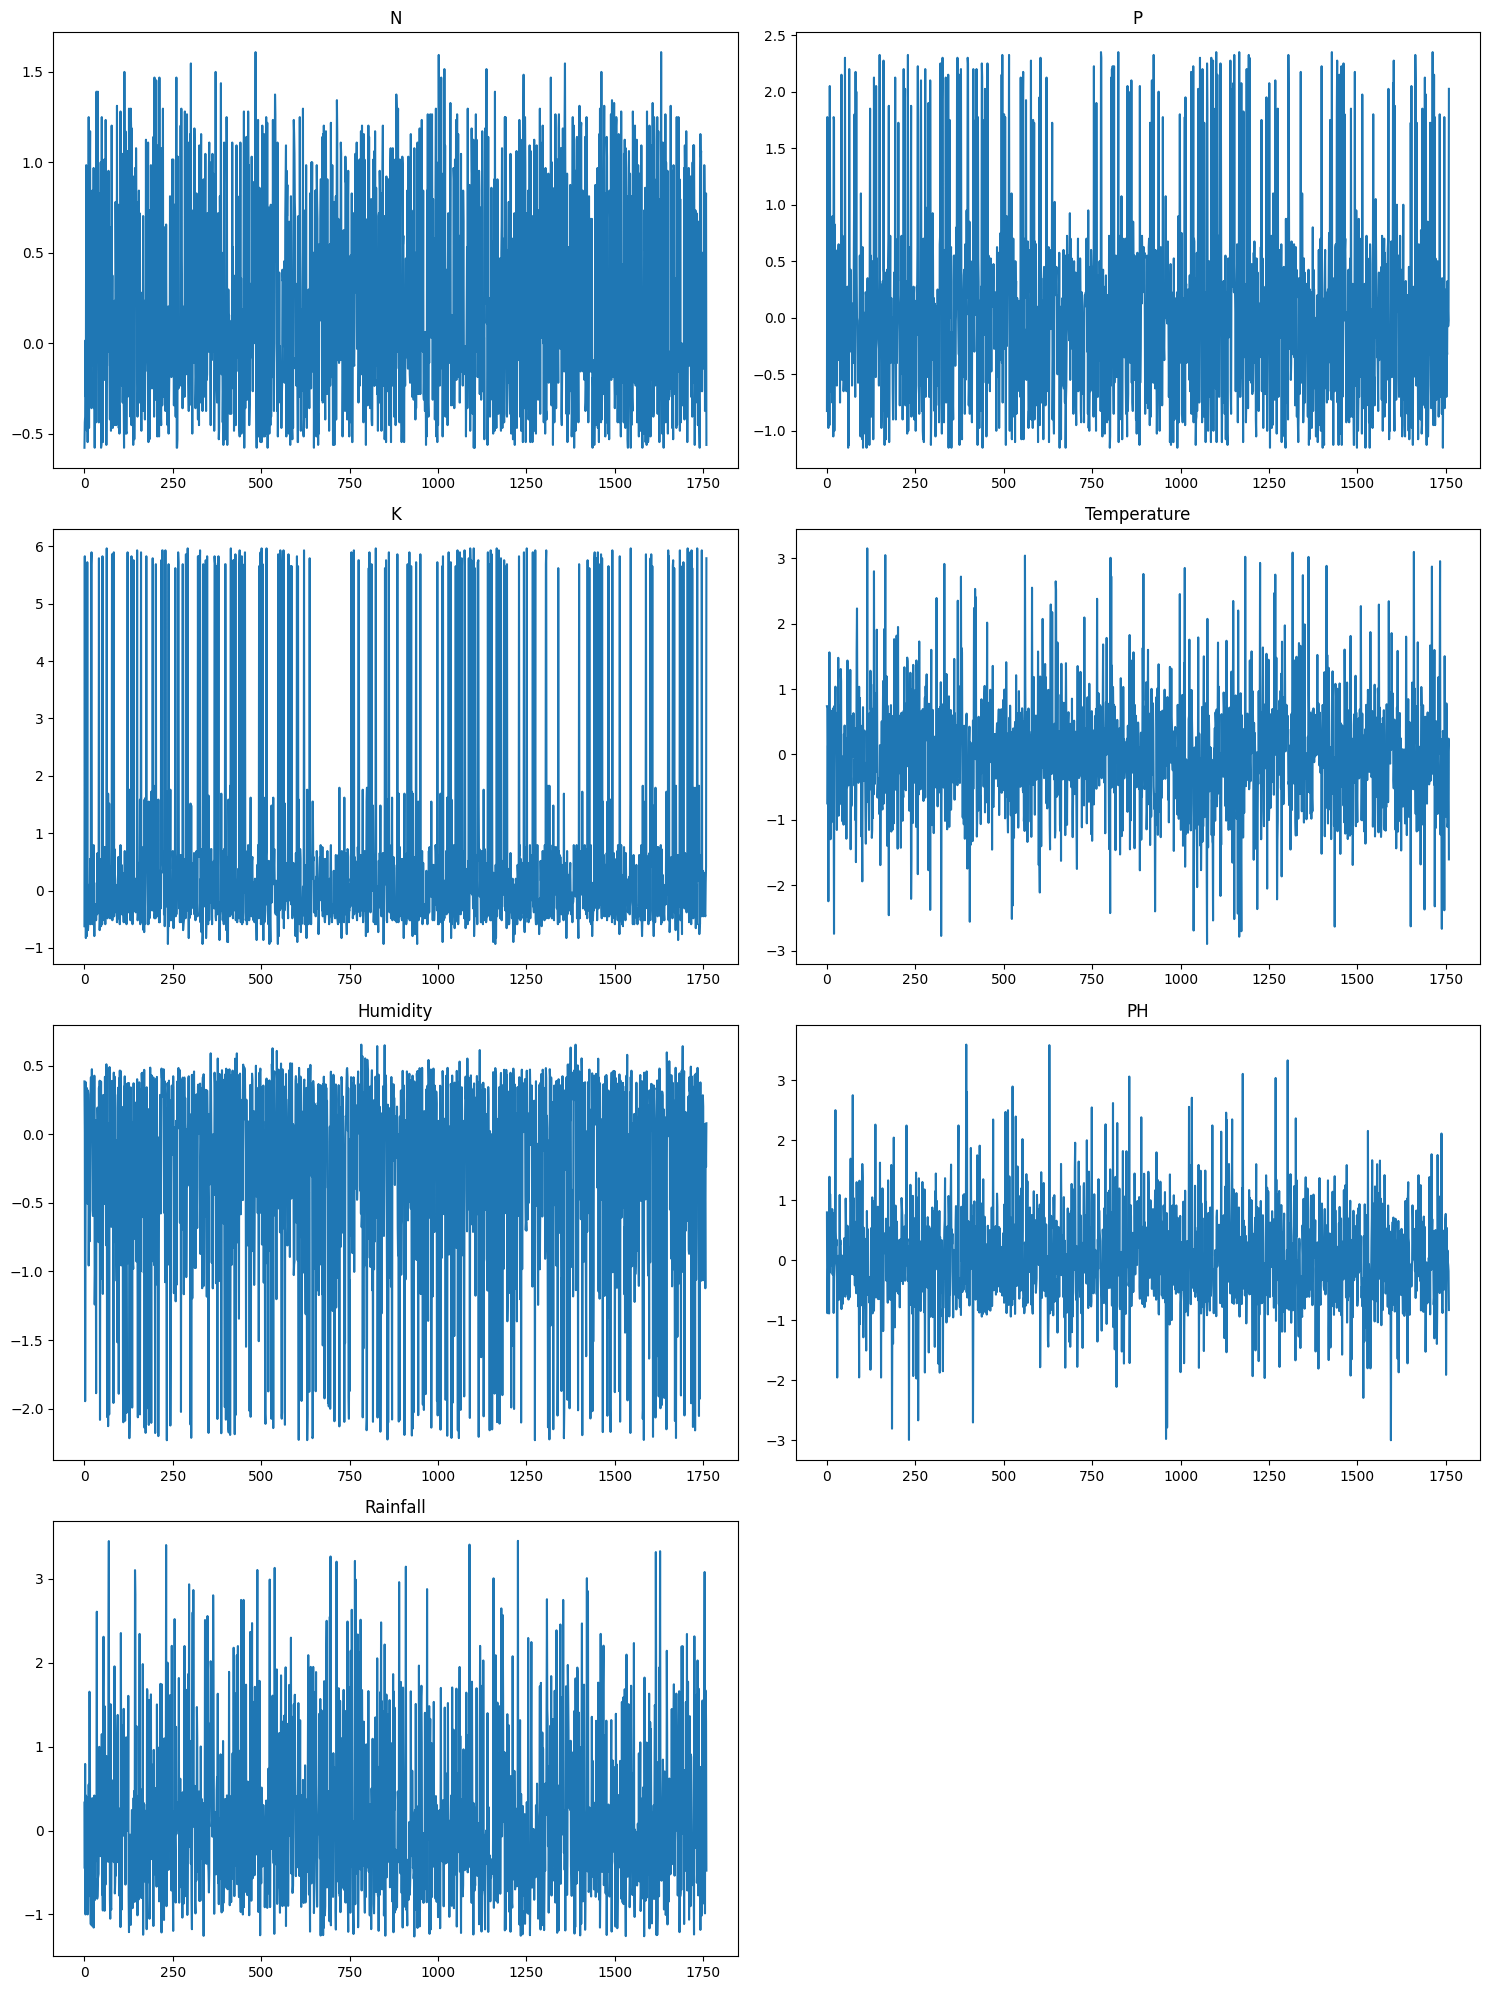

In [32]:
# Define columns
X_train_scaled_df = pd.DataFrame(transformed_x_train)
columns_to_plot = [0, 1, 2, 3, 4, 5,6]

# Calculate the number of rows and columns for subplots
num_cols = 2  # Number of columns per row
num_rows = int(np.ceil(len(columns_to_plot) / num_cols))  # Calculate rows needed

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Iterate through columns and plot
for i, column in enumerate(columns_to_plot):
    row = i // num_cols  # Calculate row index
    col = i % num_cols  # Calculate column index

    # Check if axes is a 1D array (single row)
    if num_rows == 1:
        ax = axes[col]  # Access subplot directly
    else:
        ax = axes[row, col]  # Access subplot using row and column index

    ax.plot(X_train_scaled_df[column])
    #Define titles for each column
    if column == 0:
      ax.set_title('N')
    elif column == 1:
      ax.set_title('P')
    elif column == 2:
      ax.set_title('K')
    elif column == 3:
      ax.set_title('Temperature')
    elif column == 4:
      ax.set_title('Humidity')
    elif column == 5:
      ax.set_title('PH')
    elif column == 6:
      ax.set_title('Rainfall')

# Hide any empty subplots (if total plots are not a multiple of 2)
for i in range(len(columns_to_plot), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')  # Hide empty subplot

plt.tight_layout()
plt.show()

After encoding and scaling, we will train, test, and validate the model on the following:


**Features:**
*   transformed_x_train
*   transformed_x_test
*   transformed_x_val

**Labels:**
*   transformed_y_train
*   transformed_y_test
*   transformed_y_val









Content-Based filtering

- This approach focuses on recommending crops based on their attributes (soil type, climate, etc.).

- Method: cosine similarity

In [33]:
# Assuming you have x_train as your training features DataFrame
# and y_train as the corresponding labels (Series or DataFrame)

# Calculate cosine similarity from the transformed training set
cosine_sim = cosine_similarity(transformed_x_train)

def get_content_based_recommendations(user_features, cosine_sim=cosine_sim):
    # Convert user features into a DataFrame
    user_features_df = pd.DataFrame([user_features], columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])

    # Calculate cosine similarity between user features and crops in the training set
    user_similarity = cosine_similarity(user_features_df, transformed_x_train)

    # Get pairwise similarity scores for the user's input
    sim_scores = list(enumerate(user_similarity[0]))

    # Sort the crops based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top 10 most similar crops
    sim_scores = sim_scores[1:11]  # Exclude the first entry, which will be the same crop (self-similarity)

    # Get the crop indices
    crop_indices = [i[0] for i in sim_scores]

    # Get the recommended crop names
    recommended_crops = transformed_y_train.iloc[crop_indices] # Replace 'crop' with the actual column name if different

    # Get the most common crops from the recommendations
    most_common_crops = recommended_crops.value_counts().idxmax() # Get the most frequent crop
    #encoded_array = np.array(most_common_crops).reshape(1,5)
    most_common_crops = pd.DataFrame(most_common_crops).T
    return most_common_crops

# Example user input features for recommendation
user_input = [50, 50, 50, 25, 70, 6.5, 100]  # Example feature input (N, P, K, temperature, humidity, pH, rainfall)
recommended_crops = get_content_based_recommendations(user_input)
print(recommended_crops)


   0  1  2  3  4
0  1  0  1  0  0


Collaborative Filtering

- This approach uses matrix factorization to predict interactions (e.g., user preferences) between crops, even if some interactions are missing, based on patterns in the data.

- Method: SVD

In [36]:
from surprise.model_selection import train_test_split
# Define a reader object with the appropriate rating scale
reader = Reader(rating_scale=(1, 5))

# Load the data from the DataFrame
data = Dataset.load_from_df(DF[['crop', 'N', 'P']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use the SVD algorithm for collaborative filtering
algo = SVD()

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Compute and print the RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 57.4139
RMSE: 57.413944274930046


Models Evaluation

In [45]:
# Function to evaluate content-based filtering
def evaluate_content_based():
    # Get predictions for the validation set using transformed_x_val
    y_val_pred = [get_content_based_recommendations(user_features).iloc[0] for user_features in transformed_x_val]

    # Calculate metrics
    accuracy = accuracy_score(transformed_y_val.values, y_val_pred)  # Ensure transformed_y_val is converted to a suitable format
    precision = precision_score(transformed_y_val.values, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(transformed_y_val.values, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(transformed_y_val.values, y_val_pred, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# Function to evaluate collaborative filtering
def evaluate_collaborative():
    # Make predictions on the validation set using transformed_y_val
    predictions = algo.test([(uid, iid, 0) for uid, iid in zip(y.index, y['crop'])])

    # Extract the predicted labels and convert them to the same type as transformed_y_val
    y_val_pred = [DF['crop'].iloc[int(pred.est)] for pred in predictions]

    # Calculate metrics
    accuracy = accuracy_score(y['crop'], y_val_pred)
    precision = precision_score(y, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_val_pred, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# Evaluate both models
content_based_metrics = evaluate_content_based()
collaborative_metrics = evaluate_collaborative()


# Print the results
print("Content-Based Filtering Metrics:")
print(f"Accuracy: {content_based_metrics[0]:.2f}")
print(f"Precision: {content_based_metrics[1]:.2f}")
print(f"Recall: {content_based_metrics[2]:.2f}")
print(f"F1-Score: {content_based_metrics[3]:.2f}")

print("\nCollaborative Filtering Metrics:")
print(f"Accuracy: {collaborative_metrics[0]:.2f}")
print(f"Precision: {collaborative_metrics[1]:.2f}")
print(f"Recall: {collaborative_metrics[2]:.2f}")
print(f"F1-Score: {collaborative_metrics[3]:.2f}")


Content-Based Filtering Metrics:
Accuracy: 0.96
Precision: 0.97
Recall: 0.97
F1-Score: 0.97

Collaborative Filtering Metrics:
Accuracy: 0.05
Precision: 0.00
Recall: 0.05
F1-Score: 0.00


#ML Model

In [224]:
experiment_name = "RainForest Model"
mlflow.set_experiment(experiment_name)

mlflow.start_run()

n_estimators = 1000
criterion = "gini"
random_state = 42
max_depth = 10
# Log parameters
mlflow.log_param("n_estimators", n_estimators)
mlflow.log_param("criterion", criterion)
mlflow.log_param("random_state", random_state)
mlflow.log_param("max_depth", max_depth)


# Step 1: Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,random_state=random_state,max_depth=max_depth)
rf_model.fit(transformed_x_train, transformed_y_train)

# Step 2: Define the content-based recommendation function
cosine_sim = cosine_similarity(transformed_x_train)

def get_content_based_recommendations(user_features, cosine_sim=cosine_sim):
    user_features_df = pd.DataFrame([user_features], columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])
    user_similarity = cosine_similarity(user_features_df, transformed_x_train)
    sim_scores = list(enumerate(user_similarity[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get the top 10 similar crops
    crop_indices = [i[0] for i in sim_scores]
    recommended_crops = transformed_y_train.iloc[crop_indices]
    return recommended_crops

# Step 3: Blending Function
def blended_recommendation(user_features):
    # Predict with Random Forest
    rf_prediction = rf_model.predict([user_features])[0]

    # Get content-based recommendations
    content_recommendations = get_content_based_recommendations(user_features)

    # Combine and prioritize the RF prediction
    if rf_prediction in content_recommendations.values:
        # If RF prediction is in content recommendations, prioritize it
        recommendations = content_recommendations[content_recommendations == rf_prediction]
    else:
        # Otherwise, combine RF prediction with top content recommendations
        recommendations = pd.concat([pd.Series([rf_prediction]), content_recommendations]).drop_duplicates()

    # Drop rows with NaN values
    recommendations = recommendations.dropna()

    # Return the final blended recommendation
    return recommendations

# Example user input features for recommendation
user_input = np.array([22,  30,  12 ,   15.781442,  92.510777 , 6.354007,  119.035002]).reshape(1,-1)
input_data_scaled = scaler.transform(user_input)
recommended_crops = blended_recommendation(input_data_scaled.flatten())
print("Blended Recommendations:")
print(recommended_crops)




Blended Recommendations:
      crop_0  crop_1  crop_2  crop_3  crop_4
1671       0       0       0       0       1
1633       0       0       0       0       1
1673       0       0       0       0       1
1684       0       0       0       0       1
1686       0       0       0       0       1
1653       0       0       0       0       1
1646       0       0       0       0       1
1639       0       0       0       0       1
1627       0       0       0       0       1
1642       0       0       0       0       1


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        70
           1       1.00      0.99      0.99        80
           2       0.95      1.00      0.98        40
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        10

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220



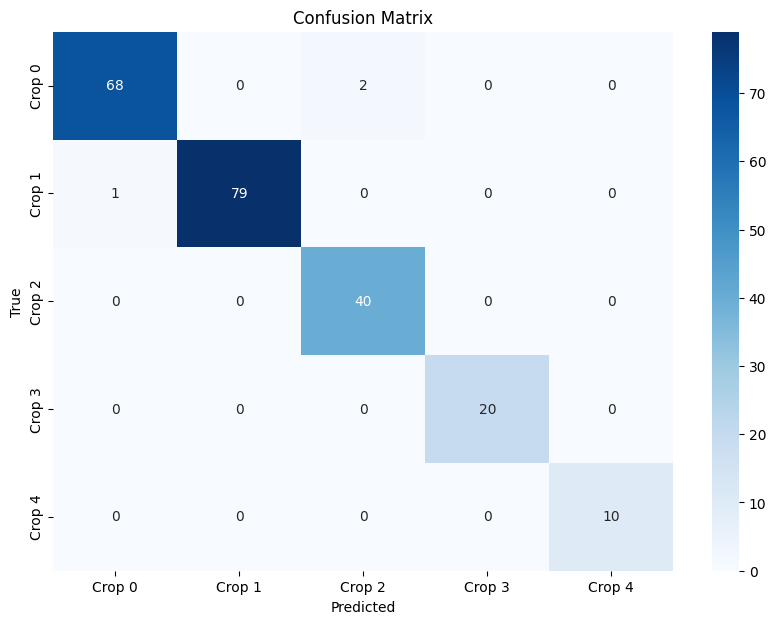

Accuracy: 0.99


In [225]:
# Make predictions
y_pred = rf_model.predict(transformed_x_test)

# Convert multilabel-indicator to single-label format
transformed_y_test_single = np.argmax(transformed_y_test, axis=1)  # Convert true labels
y_pred_single = np.argmax(y_pred, axis=1)  # Convert predicted labels

# Performance metrics
print("Classification Report:")
print(classification_report(transformed_y_test_single, y_pred_single))

# Confusion Matrix
cm = confusion_matrix(transformed_y_test_single, y_pred_single)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'], yticklabels=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy
accuracy = accuracy_score(transformed_y_test_single, y_pred_single)
print(f'Accuracy: {accuracy:.2f}')

mlflow.log_param("Accuracy", accuracy)
mlflow.end_run()

# GANS

## Define the generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # Starting with fewer units
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
           # nn.LeakyReLU(0.2),
           # nn.Linear(1024, output_dim),
            nn.Tanh()  # Output synthetic crop features
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
input_dim = 1000  # Dimension of the noise vector
output_dim = 7  # Dimension of the synthetic crop features

In [ ]:
generator = Generator(input_dim=input_dim, output_dim=output_dim)

In [ ]:

summary(generator, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         256,256
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 512]         131,584
         LeakyReLU-4                  [-1, 512]               0
            Linear-5                    [-1, 7]           3,591
              Tanh-6                    [-1, 7]               0
Total params: 391,431
Trainable params: 391,431
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


## Define the discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            #nn.Linear(input_dim, 1024),  
            #nn.LeakyReLU(0.2),
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1), 
            nn.Sigmoid()  # Sigmoid output for binary classification
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
discriminator = Discriminator(input_dim=7)

## Loss function and optimizer

In [ ]:
# Loss function (Binary Cross Entropy)
loss_function = nn.BCELoss()

# Optimizers
alpha_gen = 0.0001 
alpha_disc = 0.00001 
optimizer_G = optim.Adam(generator.parameters(), lr=alpha_gen)
optimizer_D = optim.Adam(discriminator.parameters(), lr=alpha_disc)

## Training the GAN

### Generate random noise

In [ ]:
def generate_noise(batch_size, input_dim):
    return torch.randn(batch_size, input_dim)  # Scale noise

In [ ]:
# Placeholder for real crop data (replace with your actual data)
real_samples = torch.randint(0, transformed_x_train.shape[0], (half_batch,))

In [ ]:
# Training parameters
epochs = 10000
batch_size = 32
half_batch = batch_size//2
print(half_batch)

16


In [ ]:
import torch

def add_noise(data, noise_factor):
    """Add Gaussian noise to the input data."""
    noise = torch.randn_like(data) * noise_factor
    noisy_data = data + noise
    return noisy_data


In [ ]:
experiment_name = "GAN"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/S.H%20STORES/Desktop/DEPI%20-%20Final%20Project/Code%201/mlruns/865525859049319368', creation_time=1730094851308, experiment_id='865525859049319368', last_update_time=1730094851308, lifecycle_stage='active', name='GAN', tags={}>

In [ ]:
mlflow.start_run()

# Log parameters
mlflow.log_param("input_dim", input_dim)
mlflow.log_param("output_dim", output_dim)
mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("learning_rate_generator", alpha_gen)
mlflow.log_param("learning_rate_discriminator", alpha_disc)

d_loss = 0
g_loss = 0

# Initialize lists to store losses for the learning curve
d_losses = []
g_losses = []



for epoch in range(epochs):
    # ---------------------
    # Train Discriminator
    # ---------------------
    optimizer_D.zero_grad()

    # Train on real data
    real_samples = transformed_x_train[torch.randint(0, transformed_x_train.shape[0], (half_batch,))]
    real_samples = torch.tensor(real_samples, dtype=torch.float)  # Ensure correct dtype
    real_labels = torch.full((half_batch, 1), 0.9, dtype=torch.float)  # Label smoothing for real samples
    d_loss_real = loss_function(discriminator(real_samples), real_labels)

    # Generate synthetic data (fake samples)
    noise = generate_noise(half_batch, input_dim)
    fake_samples = generator(noise).detach()  # Detach to avoid gradients flowing back
    fake_labels = torch.zeros(half_batch, 1)  # Fake samples labeled as 0
    d_loss_fake = loss_function(discriminator(fake_samples), fake_labels)

    # Combine losses and update
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # ---------------------
    # Train Generator
    # ---------------------
    optimizer_G.zero_grad()

    # Generate fake data and try to trick the discriminator
    noise = generate_noise(batch_size, input_dim)
    fake_samples = generator(noise)
    valid_labels = torch.ones(batch_size, 1)  # Labels as real for generator training

    # Generator loss: trying to make the discriminator classify fake samples as real
    g_loss = loss_function(discriminator(fake_samples), valid_labels)
    g_loss.backward()
    optimizer_G.step()

    # Store losses for the learning curve
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # Store losses for the learning curve
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # Print the progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        #Save parameters to mlflow
        mlflow.log_metric("D Loss", d_loss.item(), step=epoch)
        mlflow.log_metric("G Loss", g_loss.item(), step=epoch)

# Log models
mlflow.pytorch.log_model(generator, "generator_model")
mlflow.pytorch.log_model(discriminator, "discriminator_model")


mlflow.end_run()


Epoch 0/10000 | D Loss: 1.3955 | G Loss: 0.6873
Epoch 100/10000 | D Loss: 1.3610 | G Loss: 0.7074
Epoch 200/10000 | D Loss: 1.3415 | G Loss: 0.7147
Epoch 300/10000 | D Loss: 1.1759 | G Loss: 0.8870
Epoch 400/10000 | D Loss: 1.2653 | G Loss: 0.8754
Epoch 500/10000 | D Loss: 1.5297 | G Loss: 0.5728
Epoch 600/10000 | D Loss: 1.2780 | G Loss: 0.8177
Epoch 700/10000 | D Loss: 1.0511 | G Loss: 1.2098
Epoch 800/10000 | D Loss: 1.3900 | G Loss: 0.7305
Epoch 900/10000 | D Loss: 1.1173 | G Loss: 1.0378
Epoch 1000/10000 | D Loss: 1.1288 | G Loss: 1.0980
Epoch 1100/10000 | D Loss: 1.1105 | G Loss: 0.9392
Epoch 1200/10000 | D Loss: 1.2772 | G Loss: 0.9123
Epoch 1300/10000 | D Loss: 1.0337 | G Loss: 1.0986
Epoch 1400/10000 | D Loss: 1.5649 | G Loss: 0.6196
Epoch 1500/10000 | D Loss: 1.3322 | G Loss: 0.8245
Epoch 1600/10000 | D Loss: 1.2256 | G Loss: 1.0146
Epoch 1700/10000 | D Loss: 1.2684 | G Loss: 1.0723
Epoch 1800/10000 | D Loss: 1.3303 | G Loss: 0.8404
Epoch 1900/10000 | D Loss: 1.4128 | G Loss:

2024/10/28 21:06:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 21:06:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Generate synthetic profiles

In [ ]:
# Generate new synthetic crop profiles
num_synthetic_samples = 2000  # Define the number of synthetic samples to generate
noise = generate_noise(num_synthetic_samples, input_dim)  # GAN input noise
synthetic_features = generator(noise).detach().cpu().numpy()  # Generate synthetic crop features
# Placeholder function for synthetic labels
def generate_synthetic_labels(num_samples):
    # For now, you could randomly sample existing labels or use a heuristic to assign labels
    return transformed_y_train.sample(num_samples, replace=True).reset_index(drop=True)
synthetic_labels = generate_synthetic_labels(num_synthetic_samples)  # Function to assign labels for synthetic data


## Integrate Synthetic Data into Recommendation System

In [ ]:
# Assuming `generator` is your trained GAN generator model

# Combine real and synthetic data
combined_x_train = np.vstack([transformed_x_train, synthetic_features])
combined_y_train = pd.concat([transformed_y_train, synthetic_labels])

# Retrain the Random Forest with combined data
rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, random_state=random_state, max_depth=max_depth)
rf_model.fit(combined_x_train, combined_y_train)

# Step 2: Define the content-based recommendation function
cosine_sim = cosine_similarity(combined_x_train)

def get_content_based_recommendations(user_features, cosine_sim=cosine_sim):
    user_features_df = pd.DataFrame([user_features], columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])
    user_similarity = cosine_similarity(user_features_df, combined_x_train)
    sim_scores = list(enumerate(user_similarity[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get the top 10 similar crops
    crop_indices = [i[0] for i in sim_scores]
    recommended_crops = transformed_y_train.iloc[crop_indices]
    return recommended_crops

# Step 3: Blending Function
def blended_recommendation(user_features):
    # Predict with Random Forest
    rf_prediction = rf_model.predict([user_features])[0]

    # Get content-based recommendations
    content_recommendations = get_content_based_recommendations(user_features)

    # Combine and prioritize the RF prediction
    if rf_prediction in content_recommendations.values:
        # If RF prediction is in content recommendations, prioritize it
        recommendations = content_recommendations[content_recommendations == rf_prediction]
    else:
        # Otherwise, combine RF prediction with top content recommendations
        recommendations = pd.concat([pd.Series([rf_prediction]), content_recommendations]).drop_duplicates()

    # Drop rows with NaN values
    recommendations = recommendations.dropna()

    # Return the final blended recommendation
    return recommendations

# Example user input features for recommendation
user_input = np.array([22,  30,  12 ,   15.781442,  92.510777 , 6.354007,  119.035002]).reshape(1,-1)
input_data_scaled = scaler.transform(user_input)
recommended_crops = blended_recommendation(input_data_scaled.flatten())
print("Blended Recommendations:")
print(recommended_crops)

Blended Recommendations:
      crop_0  crop_1  crop_2  crop_3  crop_4
1671       0       0       0       0       1
1633       0       0       0       0       1
1673       0       0       0       0       1
1684       0       0       0       0       1
1686       0       0       0       0       1
1653       0       0       0       0       1
1646       0       0       0       0       1
1639       0       0       0       0       1
1627       0       0       0       0       1
1642       0       0       0       0       1


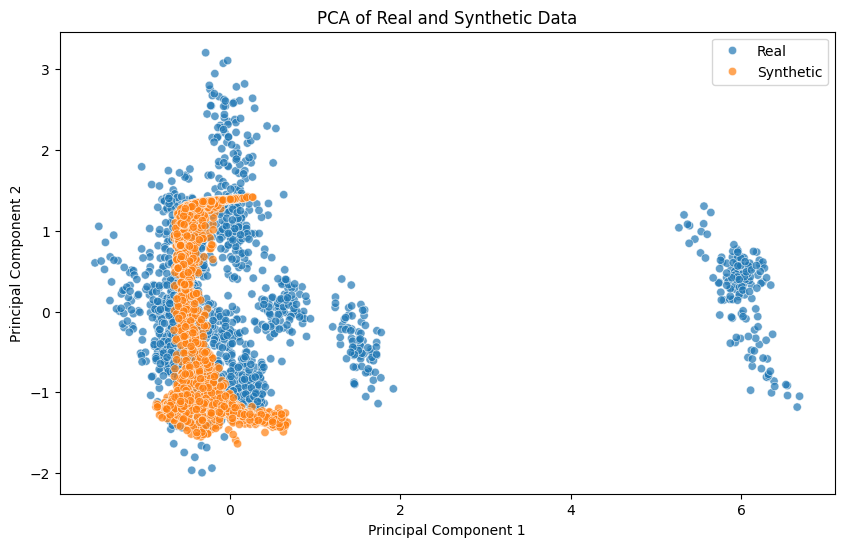

In [ ]:
from sklearn.decomposition import PCA

# Combine real and synthetic data for PCA
combined_data = np.vstack([transformed_x_train, synthetic_features])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Type'] = ['Real'] * len(transformed_x_train) + ['Synthetic'] * len(synthetic_features)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Type', alpha=0.7)
plt.title('PCA of Real and Synthetic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        20
           4       0.77      1.00      0.87        10

    accuracy                           0.99       220
   macro avg       0.95      0.99      0.97       220
weighted avg       0.99      0.99      0.99       220



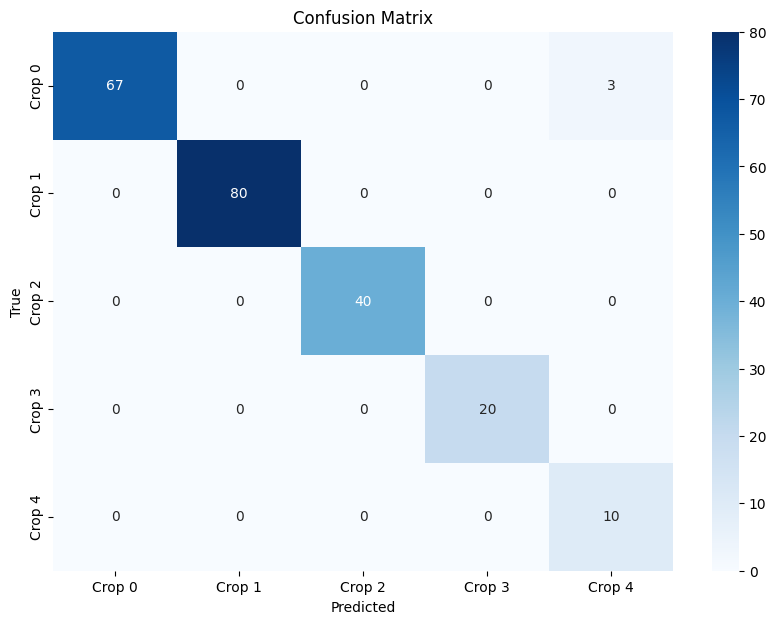

Accuracy: 0.99


In [ ]:
# Make predictions
y_pred = rf_model.predict(transformed_x_val)

# Convert multilabel-indicator to single-label format
transformed_y_val_single = np.argmax(transformed_y_val, axis=1)  # Convert true labels
y_pred_single = np.argmax(y_pred, axis=1)  # Convert predicted labels

# Performance metrics
print("Classification Report:")
print(classification_report(transformed_y_val_single, y_pred_single))

# Confusion Matrix
cm = confusion_matrix(transformed_y_val_single, y_pred_single)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'], yticklabels=['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy
accuracy = accuracy_score(transformed_y_val_single, y_pred_single)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
real_df = pd.DataFrame(DF, columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])
synthetic_profiles_df = pd.DataFrame(synthetic_profiles, columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])

# Combine real and synthetic data
augmented_data = pd.concat([real_df, synthetic_profiles_df], ignore_index=True)

# Recompute cosine similarity and run recommendation
cosine_sim_augmented = cosine_similarity(augmented_data)
prediction = np.array(get_content_based_recommendations([90,42,43,20.879744,82.002744,6.502985,202.935536], cosine_sim=cosine_sim_augmented)).reshape(1,5)
print(prediction)


[[0 1 1 1 1]]


#Deployment

## Save the Model as PKL file


In [226]:
import pickle 

file_name = "rainforest_model.pkl"

import importlib
importlib.reload(pickle)  

with open(file_name, 'wb') as model_file:
    pickle.dump(rf_model, model_file)  

In [227]:
file_name = "rainforest_model.sav"

import importlib
importlib.reload(pickle)  

with open(file_name, 'wb') as model_file:
    pickle.dump(rf_model, model_file)  

In [228]:
#Save the Scaler
with open('scaler.sav', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)